<a href="https://colab.research.google.com/github/banrovegrie/Nostradamus/blob/main/src/Nostradamus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import snowflake.connector
except:
    !pip install snowflake-connector-python
    import snowflake.connector

from pprint import pprint
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files
import requests

try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

/usr/local/lib/python3.7/dist-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
  _expected_pyarrow_version,


In [2]:
#create connection
conn=snowflake.connector.connect(
    user='ZSHAN0',
    password='Zee@snowflack0',
    account='pg84506.ap-south-1.aws',
    database='US_STOCKS_DAILY',
)

In [3]:
def showTables(curs):
  curs.execute("SHOW TABLES")

  tables = [x[1] for x in curs.fetchall()]
  return tables

In [4]:
curs=conn.cursor()
curs.execute("SHOW TABLES")
tables = showTables(curs)
tables

['COMPANY_PROFILE', 'STOCK_HISTORY', 'SYMBOLS']

In [5]:
columnNames = {
    'COMPANY_PROFILE': [], 
    'STOCK_HISTORY': [], 
    'SYMBOLS': [], 
}

In [6]:
curs.execute("DESCRIBE SYMBOLS")
res = curs.fetchall()
[x[0] for x in res]

['ID', 'SYMBOL', 'NAME', 'EXCHANGE']

# Getting data

In [7]:
def getColumns(curs, tableName):
    curs.execute(f"DESCRIBE {tableName}")
    return [x[0] for x in curs.fetchall()]

In [8]:
for table in tables:
    print(getColumns(curs, table))

['ID', 'SYMBOL', 'PRICE', 'BETA', 'VOLAVG', 'MKTCAP', 'LASTDIV', 'RANGE', 'CHANGES', 'COMPANYNAME', 'EXCHANGE', 'INDUSTRY', 'WEBSITE', 'DESCRIPTION', 'CEO', 'SECTOR', 'DCFDIFF', 'DCF']
['ID', 'SYMBOL', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'ADJCLOSE']
['ID', 'SYMBOL', 'NAME', 'EXCHANGE']


In [9]:
def getData(curs, tableName, numRows=0):
    if numRows == 0:
        curs.execute(f"SELECT * FROM {tableName}")
    else:
        curs.execute(f"SELECT * FROM {tableName} LIMIT {numRows}")
    rows = curs.fetchall()
    columnNames = getColumns(curs, tableName)
    df = pd.DataFrame(rows, columns=columnNames)
    return df

In [10]:
symbols = getData(curs, 'SYMBOLS')
symbols

,ID,SYMBOL,NAME,EXCHANGE
0,28674,SPY,SPDR S&P 500,NYSE Arca
1,28675,CMCSA,Comcast Corp,Nasdaq Global Select
2,28676,KMI,Kinder Morgan Inc,New York Stock Exchange
3,28677,INTC,Intel Corp,Nasdaq Global Select
4,28678,MU,Micron Technology Inc,Nasdaq Global Select
...,...,...,...,...
10908,43096,GOED,1847 Goedeker Inc.,NYSE American
10909,43098,RXT,"Rackspace Technology, Inc.",NasdaqGS
10910,43102,TCEHY,Tencent Holdings Limited,Other OTC
10911,43105,PROSY,Prosus N.V.,Other OTC


In [11]:
def getCompanySymbols():
    return list(set(symbols['SYMBOL'].tolist()))

In [12]:
getCompanySymbols()

['CIFS',
 'UEC',
 'LOWC',
 'EHI',
 'EROS',
 'TSQ',
 'ITEQ',
 'GERM',
 'FUE',
 'TEO',
 'WH',
 'SCHR',
 'WCHN',
 'BDN',
 'PDC.TO',
 'XENE',
 'ZGD.TO',
 'KHC',
 'FLS',
 'PR.TO',
 'SLBEN.LS',
 'GTT',
 'GEA.PA',
 'AA',
 'BF-B',
 'DEF',
 'MXF.TO',
 'RNEM',
 'SIP.BR',
 'CRDF',
 'GOODN',
 'NRG',
 'FXF',
 'MVC',
 'ALPAT.PA',
 'QRH.TO',
 'TEI',
 'ESGE',
 'HEWJ',
 'JJE',
 'BCI.TO',
 'APRN',
 'GNAF',
 'WPX',
 'YNDX',
 'IWC',
 'MUS.TO',
 'ANFI',
 'ZTS',
 'ERY',
 'NSPR',
 'YAYO',
 'NIHD',
 'ROAN',
 'LMLP',
 'MGF',
 'TPB',
 'GNFT',
 'GLCN',
 'ECT.AS',
 'IBTH',
 'ALERS.PA',
 'ORP.PA',
 'BFIT',
 'EMD',
 'RVSB',
 'RHE',
 'EYEN',
 'UEUR',
 'CDC',
 'AMD',
 'ZUO',
 'HROW',
 'DBV.PA',
 'UGA',
 'CODX',
 'MEET',
 'IGICW',
 'RIV',
 'STSA',
 'SEIC',
 'MOBL',
 'TCBIP',
 'MLMAT.PA',
 'BPYU',
 'FTCS',
 'NWSA',
 'NMR',
 'MGEN',
 'MRVL',
 'BKCC',
 'CETXW',
 'BCP.LS',
 'VCYT',
 'FTSD',
 'ANSS',
 'SPLB',
 'NH',
 'SBE',
 'DO',
 'HTZ',
 'EIGI',
 'ARCE',
 'ALMIL.PA',
 'WCM-A.TO',
 'MFG',
 'SPGM',
 'KOSS',
 'AWP',
 'AI.PA

In [13]:
def getDataFromSymbols(curs, symbol, numRows=0):
    if numRows == 0:
        curs.execute(f"SELECT * FROM STOCK_HISTORY WHERE SYMBOL='{symbol}'")
    else:
        curs.execute(f"SELECT * FROM STOCK_HISTORY WHERE SYMBOL='{symbol}' LIMIT {numRows}")
    rows = curs.fetchall()
    columnNames = getColumns(curs, "STOCK_HISTORY")
    df = pd.DataFrame(rows, columns=columnNames)
    return df

In [14]:
aapl = getDataFromSymbols(curs, 'AAPL')
len(aapl)

10278

In [15]:
aapl.sort_values(by=["DATE"], inplace = True)


In [16]:
# aapl.to_csv(r'aapl.csv', index = False, header = True)
# files.download('aapl.csv') 

In [17]:
def saveData(curs, symbolList):
    for company in symbolList:
        df = getDataFromSymbols(curs, company)
        df.sort_values(by=["DATE"], inplace = True)
        df.to_csv(f'{company}.csv', index = False, header = True)
        files.download(f'{company}.csv') 

In [18]:
# saveData(curs, 
#          [
#           "ADM", "BAYRY", "BG", "SMG"
#           "AAPL", "BP", "CVX", 
#           "XOM", "EPD", "COP", "EOG", "NRG", "XEL",  # energy companies
#           "GNRC", "PPSI", "VST" # electronics
#          ]
#          )

# Environment Data

In [19]:
curs.execute("USE ENV")

In [20]:
tables = showTables(curs)
tables

['DATASETS', 'DATA_ATLAS']

In [21]:
datasets = getData(curs, "DATASETS")
data_atlas = getData(curs, "DATA_ATLAS")

In [22]:
data_atlas.head()

,Dataset,Path,Country,Country ISO Code,Topic,Subtopic,Indicator,Description,Source,Uri,Year,Month,Unit,Date,Value
0,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1970,1,Mton CO2,1970-01-01,19.43696
1,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1971,1,Mton CO2,1971-01-01,25.40343
2,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1972,1,Mton CO2,1972-01-01,27.71823
3,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1973,1,Mton CO2,1973-01-01,35.80548
4,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1974,1,Mton CO2,1974-01-01,35.97032


# Cleaning Data

`location=AE;indicator=KN.F1;type=All;Frequency=A`

To split the values into different columns

In [23]:
def splitPath(string, originalAttr):
    string = string.lower()
    l = string.split(';')
    for x in l:
        attr, val = x.split('=')
        if attr == originalAttr:
            return val
    return None

In [24]:
attributesList = []
def func(string):
    l = string.split(';')
    for x in l:
        attr, val = x.split('=')
        attributesList.append(attr)

data_atlas.apply(lambda x: func(x['Path']), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
339447    None
339448    None
339449    None
339450    None
339451    None
Length: 339452, dtype: object

In [25]:
data_atlas['location'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'location'), axis=1)
data_atlas['indicator'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'indicator'), axis=1)
data_atlas['type'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'type'), axis=1)
data_atlas['frequency'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'frequency'), axis=1)
data_atlas['series'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'series'), axis=1)
data_atlas['variable'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'variable'), axis=1)

# Removing Unnecessary columns

In [26]:
data_atlas.drop(['Path', 'Country', 'Dataset', 'Source', 'Uri', 'Year', 'Month'], axis=1, inplace=True)

In [27]:
data_atlas.head()

,Country ISO Code,Topic,Subtopic,Indicator,Description,Unit,Date,Value,location,indicator,type,frequency,series,variable
0,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1970-01-01,19.43696,ae,kn.f1,all,a,None,None
1,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1971-01-01,25.40343,ae,kn.f1,all,a,None,None
2,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1972-01-01,27.71823,ae,kn.f1,all,a,None,None
3,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1973-01-01,35.80548,ae,kn.f1,all,a,None,None
4,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1974-01-01,35.97032,ae,kn.f1,all,a,None,None


In [28]:
curs.execute('select DISTINCT "Indicator" from DATA_ATLAS')
indicators = list(set([x[0] for x in curs.fetchall()]))

In [29]:
def env_data(country, indicator):
    data_val = data_atlas[(data_atlas['Indicator'] == indicator) & (data_atlas['Country ISO Code'] == country)]
    data_val['Year'] = data_val.apply(lambda x: x["Date"].year, axis=1)
    return data_val[['Year', 'Value']]

# Getting data about the companies sustainibility

In [30]:
def yearlyData(attribute, companyName):
    df = yf.download(tickers=companyName, period='max', interval='3mo', threads=True)
    df = df[df[attribute].notna()]
    df['Year'] = df.apply(lambda x: x.name.year, axis=1)
    df = df.groupby(['Year']).mean()
    df['Year'] = df.index
    df.reset_index(drop=True, inplace=True)
    return df

In [31]:
def mergeOnYear(attribute, country, company, indicator):
    yearly = yearlyData(attribute, company)
    x = yearly[[attribute, 'Year']]
    y = env_data(country, indicator)
    xy = pd.merge(x, y, on='Year', how='inner') 
    return xy

In [32]:
def correlation(attr, country, company, indicator):
    df_cov = mergeOnYear(attr, country, company, indicator)
    return df_cov[attr].corr(df_cov['Value'])

In [33]:
def plot_correlation(attr, country, company, indicator):
    df_cov = mergeOnYear(attr, country, company, indicator)
    print(df_cov.head())
    print()
    print("Correlation = ", df_cov[attr].corr(df_cov['Value']))
    print()
    plt.plot(df_cov['Year'], (df_cov[attr] - df_cov[attr].min())/(df_cov[attr].max() - df_cov[attr].min()))
    plt.plot(df_cov['Year'], (df_cov['Value'] - df_cov['Value'].min())/(df_cov['Value'].max() - df_cov['Value'].min()))

[*********************100%***********************]  1 of 1 completed
        Open  Year       Value
0  11.382812  1985  4775.39958
1  11.656250  1986  4734.69220
2  16.757812  1987  4892.10505
3  13.593750  1988  5115.29985
4  14.382812  1989  5172.66620

Correlation =  0.8158776413348325



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


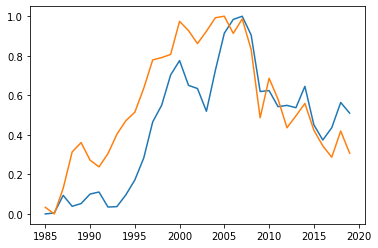

In [34]:
plot_correlation('Open', 'US', 'BP', 'CO2 emissions')

# Correlation between indicators and company prices

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dis

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dis

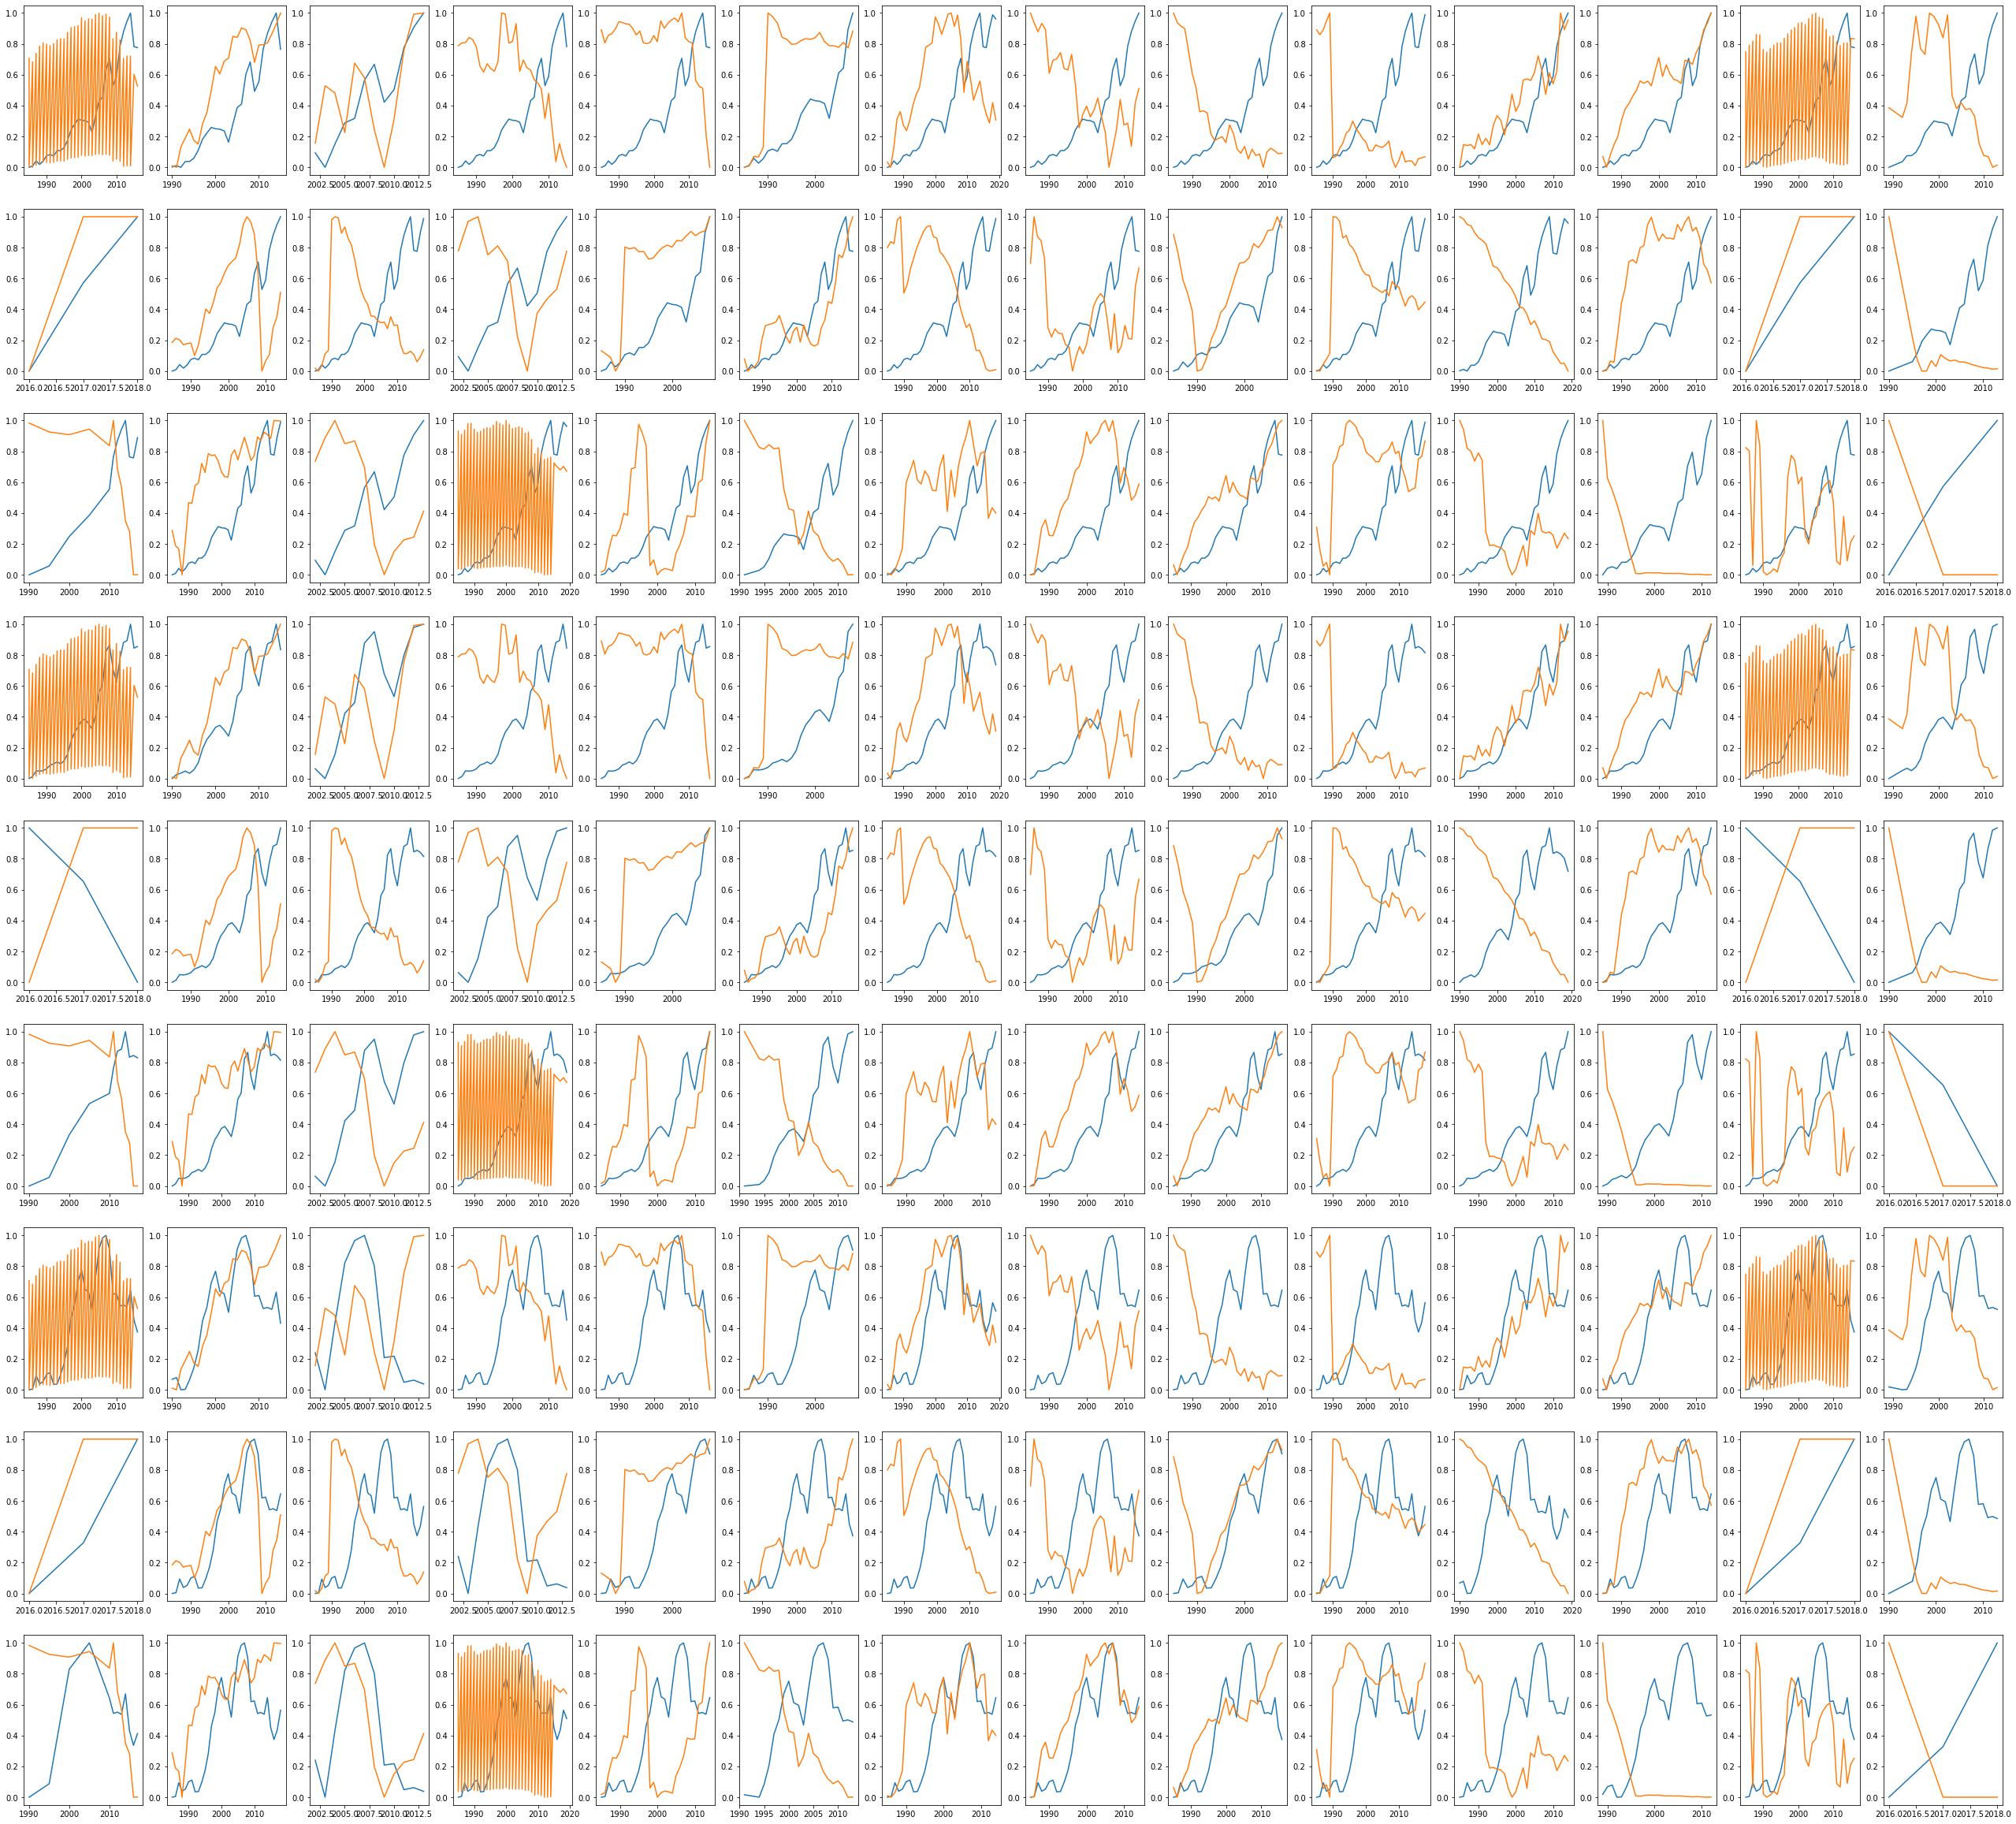

In [37]:
companies = ["CVX", "XOM", "BP", "AAPL", "SPY"]
count = 0
corList = []
plt.figure(figsize=(45, 42))
for company in companies:
    try:
        yearly = yearlyData("Open", company)
        x = yearly[['Open', 'Year']]
    except:
        counter += len(indicators)
        continue
    for indicator in indicators:
        try:
            y = env_data('US', indicator)
            df_cov = pd.merge(x, y, on='Year', how='inner') 
            correl = df_cov['Open'].corr(df_cov['Value'])
            if np.isnan(correl):
                continue
            count += 1
            corList.append([indicator, company, correl])
            plt.subplot(9, 14, count)
            plt.plot(df_cov['Year'], (df_cov['Open'] - df_cov['Open'].min())/(df_cov['Open'].max() - df_cov['Open'].min()))
            plt.plot(df_cov['Year'], (df_cov['Value'] - df_cov['Value'].min())/(df_cov['Value'].max() - df_cov['Value'].min()))
            plt.set_title(count)
        except:
            continue

In [36]:
corDf = pd.DataFrame(data=corList, columns=["Indicator", "Company", "Open Correlation"])
corDf = corDf[corDf['Open Correlation'].notna()]
corDf = corDf.sort_values(by='Open Correlation', ascending=False)
corDf

,Indicator,Company,Open Correlation
145,CO2 emissions from gaseous fuel consumption (%),AAPL,0.928604
140,Terrestrial protected areas,AAPL,0.908637
152,Terrestrial and marine protected areas,AAPL,0.908637
52,CO2 emissions: transport (%),XOM,0.906557
10,CO2 emissions: transport (%),CVX,0.906016
...,...,...,...
41,Marine protected areas,CVX,-0.904345
91,CO2 emissions: residential buildings (%),BP,-0.907994
167,Marine protected areas,AAPL,-0.908637
66,CO2 emissions intensity,XOM,-0.946313
